In [1]:
!rm -rf /content/looped_transformer/

In [2]:
!git clone https://github.com/DMurawiecki/looped_transformer.git
!ls

Cloning into 'looped_transformer'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 240 (delta 85), reused 57 (delta 57), pack-reused 136
Receiving objects: 100% (240/240), 852.88 KiB | 13.76 MiB/s, done.
Resolving deltas: 100% (142/142), done.
__notebook__.ipynb  looped_transformer


In [3]:
!pip install funcy
!pip3 install -U zetascale

In [4]:
import sys
import torch
import numpy
import yaml
import os
sys.path.append('/kaggle/working/looped_transformer/')
sys.path.append('/kaggle/working/looped_transformer/scripts/')
from models import build_model
from tasks import get_task_sampler
from nano_gpt import GPT2Model, GPT2Config, LayerNorm
import matplotlib.pyplot as plt
from tqdm import tqdm
from main_utils import gen_dataloader
from models import TransformerModel, TransformerModelLooped
from curriculum import *
from train import calculate_gradient_norm
from train_implementation import train_model, train_step
from utilities import set_optim_scaler_curriculum_by_args
from eval_and_save import save_model

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
starting_step = 0
ending_step = 150000
ctx = True

torch.set_float32_matmul_precision('highest')
torch.backends.cuda.matmul.allow_tf32 = True  # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True  # allow tf32 on cudnn
dtype = 'float16'  # 'bfloat16', 'float32'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

# Train Looped Model without logging to Weights&Biases

number of parameters: 0.79M


  0%|          | 0/150000 [00:00<?, ?it/s]

0


100%|██████████| 150000/150000 [3:07:25<00:00, 13.34it/s]


your model was saved


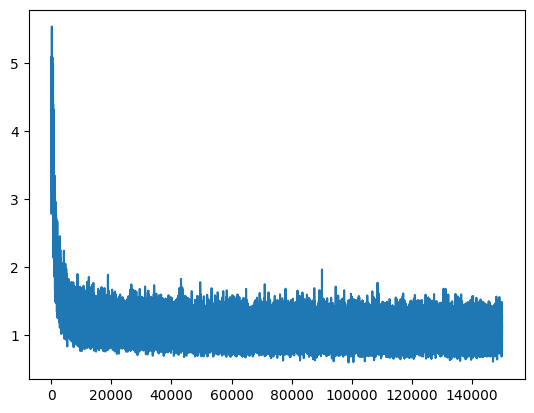

In [6]:
n_positions = 101
n_embd = 256
n_head = 8
n_dims= 4
T = 500
n_layer = 1
torch.manual_seed(42)
args_path = '/kaggle/working/looped_transformer/configs/base_loop_4dim.yaml'

model_loop = TransformerModelLooped( n_dims, n_positions, n_embd, n_layer, n_head).to(device)

optimizer_loop, scaler_loop, curriculum_loop, args_loop = set_optim_scaler_curriculum_by_args(args_path=args_path, model= model_loop)
losses= train_model(starting_step=starting_step ,
                     ending_step= ending_step,
                     args= args_loop,
                     model= model_loop,
                     ctx= ctx,
                     add_inputs_embeds= True,
                     optimizer = optimizer_loop,
                     curriculum = curriculum_loop,
                     scaler = scaler_loop,
                     device = device)
save_model(model_loop, path= '/kaggle/working/state_loop_4dim.pt')
plt.plot(losses)